In [222]:
import os
import sys
from pathlib import Path

import anndata as ad
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.pyplot import rc_context
from skimage import exposure, io
from skimage.util import img_as_ubyte
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm, trange
from matplotlib.patches import Patch

sc.settings.verbosity = 3

In [223]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [224]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import scanorama
import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [225]:
experiment = "Tonsil"
cores=['DonorA', 'DonorE']
# cores = ['B5', 'C6', 'D4', 'E4', 'E6', 'F4', 'F7']
datasets = [f'{core}_{i}' for core in cores for i in range(1,7)]
# datasets = ['E6_1', 'E6_2', 'E6_3']

# Load data

In [226]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


In [227]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [228]:
adatas = []
df_sums = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    data_all = df_intensity_TS.iloc[:, 1:].values
    # data_all_norm = (data_all+0.1)/(np.percentile(data_all,50,axis=1,keepdims=True)+0.1)
    # data_all_norm = MinMaxScaler().fit_transform(data_all)
    # df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_TS
    df.set_index("Id", inplace=True)
    df_sums.append(df.sum(axis=0))
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    adatas.append(adata)
adata = ad.concat(adatas, join="inner")

Sucessfully read dataset DonorA_1
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_2160/1887427505.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorA_2
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorA_3
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorA_4
normalizing counts per cell
    finished ({time_passed})
Sucessfully read dataset DonorA_5
normalizing counts per cell
    finished ({time_passed})
DonorA_6 cannot be read
Sucessfully read dataset DonorE_1
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorE_2
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorE_3
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorE_4
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorE_5
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset DonorE_6
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [229]:
df_sum = pd.concat(df_sums, axis=1).mean(axis=1)
mz_qc = df_sum[(df_sum > 65000)].index.tolist()

In [230]:
# Read Protein clustering info
path = data_dir / "adata" / f"{experiment}_GC.h5ad"
adata_IMC_cluster = ad.read_h5ad(path)


# Load IMC

In [231]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


## Create Neighbor graph

In [232]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.cluster import MiniBatchKMeans
from matplotlib.ticker import MaxNLocator
from skimage import morphology, measure, exposure
from scipy import ndimage


def get_NN(adata, n):
    data = adata.obsm["spatial"]
    # fit = NearestNeighbors(n_neighbors=n + 1).fit(data)
    fit = NearestNeighbors(n_neighbors=n).fit(data)
    m = fit.kneighbors(data)
    # m = m[0][:, 1:], m[1][:, 1:]
    m = m[0], m[1] # Distances, Indices

    # sort_neighbors
    args = m[0].argsort(axis=1)
    add = (
        np.arange(m[1].shape[0]) * m[1].shape[1]
    )  # arange for number of elements with step of number of neighbors
    sorted_indices = m[1].flatten()[
        args + add[:, None]
    ]  # Extract indices in sorted order
    return sorted_indices


def neighbor_frequency(adata, n):
    dummies = pd.get_dummies(adata.obs["leiden"]).values
    cols = get_NN(adata, n)
    window = dummies[cols].flatten()
    window = window.reshape(-1, n, dummies.shape[1])
    window = window.sum(axis=1) / n
    assert len(window) == len(adata.X)
    return window

In [233]:
n_neighbors = 20
windows = []

for d in adata_IMC_cluster.obs.Core.unique():
    adata_subset = adata_IMC_cluster[adata_IMC_cluster.obs.Core == d, :]

    # sq.gr.spatial_neighbors(adata_subset, n_neighs=n_neighbors)
    window = neighbor_frequency(adata_subset, n_neighbors)
    assert len(window) == len(adata_subset.X)

    windows.append(window)

windows = np.concatenate(windows)
windows.shape

(31156, 10)

In [234]:
adata_CN = ad.AnnData(windows)
adata_CN.raw = adata_IMC_cluster.copy()
adata_CN.obs = adata_IMC_cluster.obs.copy()
adata_CN.uns = adata_IMC_cluster.uns.copy()
adata_CN.obsm = adata_IMC_cluster.obsm.copy()
adata_CN.obsp = adata_IMC_cluster.obsp.copy() 
adata_CN.var_names = pd.get_dummies(adata_IMC_cluster.obs["leiden"]).columns.to_list()

C:\Users\thu71\AppData\Local\Temp/ipykernel_2160/2906281834.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_CN = ad.AnnData(windows)
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


computing PCA
    with n_comps=5
    finished (0:00:00)


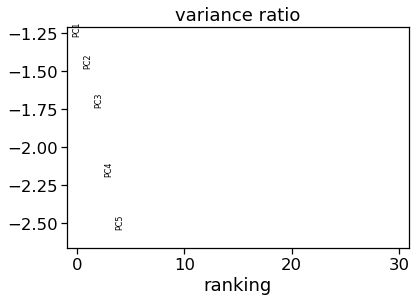

In [235]:
sc.tl.pca(adata_CN, n_comps=5)
sc.pl.pca_variance_ratio(adata_CN, log=True)


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variab

The suggested number of clusters =  6


C:\Users\thu71\AppData\Local\Temp/ipykernel_2160/406897452.py:30: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title("The suggested number of clusters = " + np.str(kneedle_point.knee))


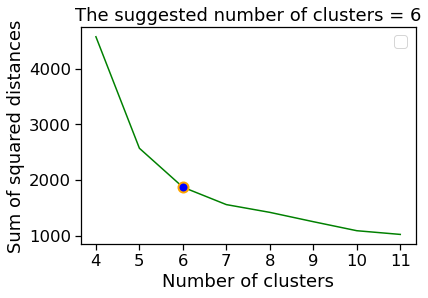

In [236]:
proj_3d = adata_CN.obsm['X_pca']

n_components = np.arange(4, 12)
models = [
    MiniBatchKMeans(random_state=5, n_clusters=n).fit(proj_3d) for n in n_components
]

BIC_Scores = [m.inertia_ for m in models]
kneedle_point = KneeLocator(
    n_components, BIC_Scores, curve="convex", direction="decreasing"
)
print("The suggested number of clusters = ", kneedle_point.knee)
Elbow_idx = np.where(BIC_Scores == kneedle_point.knee_y)[0]

plt.plot(
    n_components,
    BIC_Scores,
    "-g",
    marker="o",
    markerfacecolor="blue",
    markeredgecolor="orange",
    markeredgewidth="2",
    markersize=10,
    markevery=Elbow_idx,
)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc="best")
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distances")
plt.title("The suggested number of clusters = " + np.str(kneedle_point.knee))
plt.show()

In [237]:
n_neighborhoods = 6

km = MiniBatchKMeans(n_clusters=n_neighborhoods, random_state=0)

labels = km.fit_predict(proj_3d)
k_centroids = km.cluster_centers_

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [238]:
adata_CN.obs["CN"] = labels
adata_CN.obs["CN"] = adata_CN.obs["CN"].astype("category")
adata_CN.uns["CN_colors"] = adata_IMC_cluster.uns["leiden_colors"][:len(np.unique(labels))]

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_CN']`


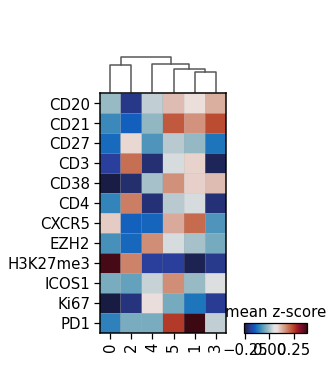

In [239]:
sc.tl.dendrogram(adata_CN, groupby='CN')

sns.set_context("notebook", font_scale=1.5)
sc.pl.matrixplot(
    adata_CN,
    adata_CN.raw.var_names.tolist(),
    "CN",
    dendrogram=True,
    colorbar_title="mean z-score",
    cmap=heatmap_cmp,
    swap_axes=True,
    use_raw=True,
    # vmin=0,
    # vmax=0.3
)

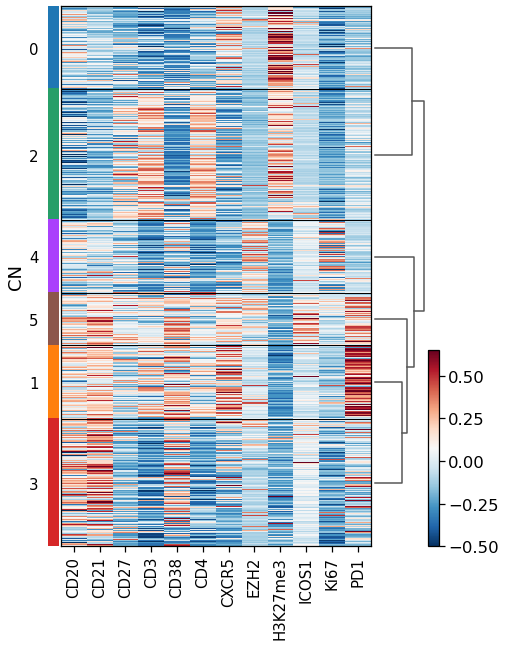

In [240]:
sc.pl.heatmap(
    adata_CN,
    adata_CN.raw.var_names.tolist(),
    "CN",
    dendrogram=True,
    cmap="RdBu_r",
    figsize=(7, 10),
    vmin=-0.5,
    vmax=0.65
)

In [241]:
cluster_label_order = adata_CN.uns['dendrogram_CN']['categories_ordered']

In [242]:
import matplotlib 

colors = adata_CN.uns["CN_colors"]
labels = adata_CN.obs.CN.cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

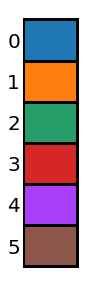

In [243]:
# legend
fig, ax = plt.subplots(figsize=(1,5))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=np.array(list(colors_rgb_dict.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), colors_rgb_dict.keys(), rotation=0, size=20)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


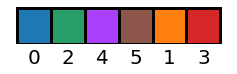

In [244]:
# legend
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

fig, ax = plt.subplots(figsize=(4,0.7))
ax.bar(x=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.xticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=20)
_ = plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.grid(False)


## Plot cell mask

In [245]:
from typing import List
import matplotlib
import skimage
from skimage import measure


def get_masks(mask_folder, dataset):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name and dataset in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for i, cells in tqdm(label2cell.items(), total=len(label2cell)):
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]

    return img


def get_contour(mask: np.ndarray) -> List[List[float]]:
    """
    Get contours of mask
    """
    contours = []
    for i in sorted(np.unique(mask)):
        if i == 0:
            continue
        contours.append(measure.find_contours(mask == i, 0.8)[0])

    return contours

In [246]:
experiment='tonsil'

In [247]:
masks = get_masks(data_dir / "masks", f"{experiment}")

In [248]:
colors = adata_CN.uns["CN_colors"]
labels = np.unique(adata_CN.obs.CN.tolist())

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

  0%|          | 0/6 [00:00<?, ?it/s]

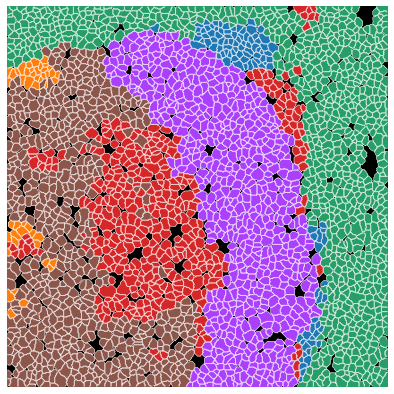

  0%|          | 0/6 [00:00<?, ?it/s]

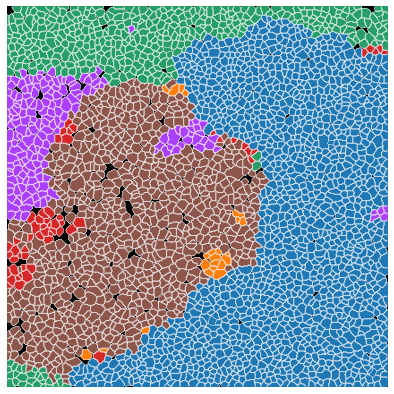

  0%|          | 0/6 [00:00<?, ?it/s]

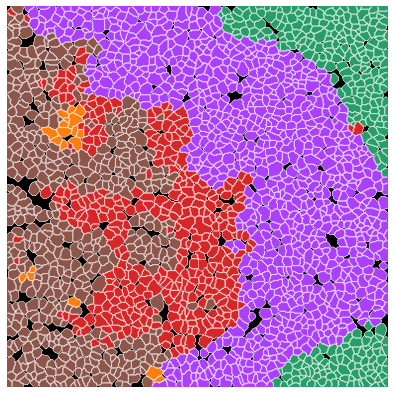

  0%|          | 0/6 [00:00<?, ?it/s]

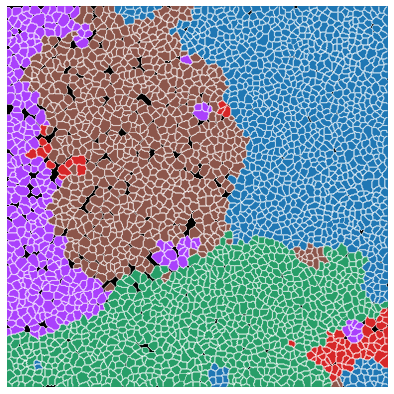

  0%|          | 0/6 [00:00<?, ?it/s]

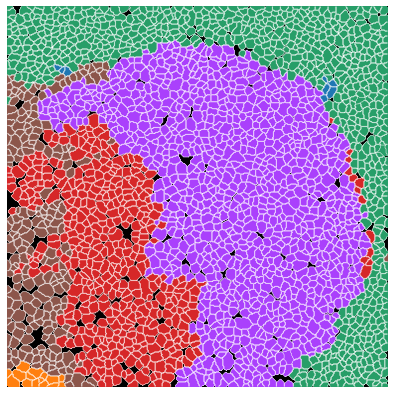

  0%|          | 0/6 [00:00<?, ?it/s]

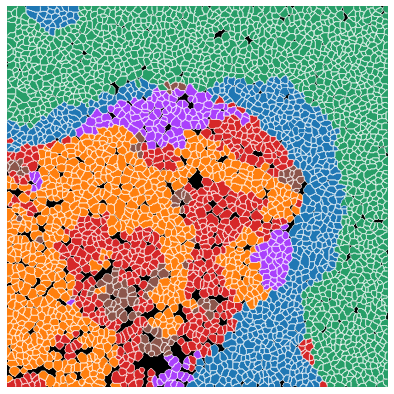

  0%|          | 0/6 [00:00<?, ?it/s]

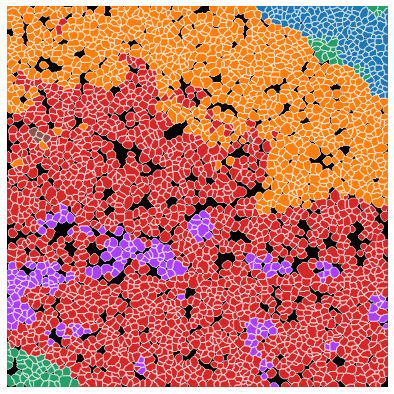

  0%|          | 0/6 [00:00<?, ?it/s]

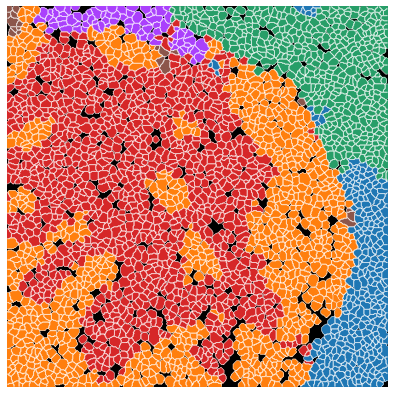

  0%|          | 0/6 [00:00<?, ?it/s]

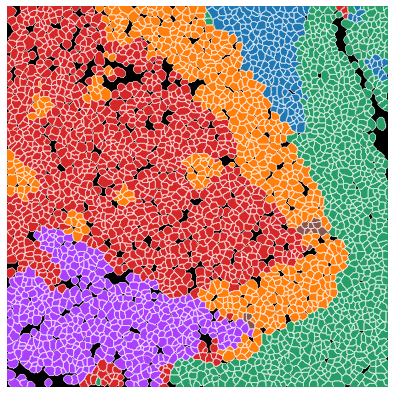

  0%|          | 0/6 [00:00<?, ?it/s]

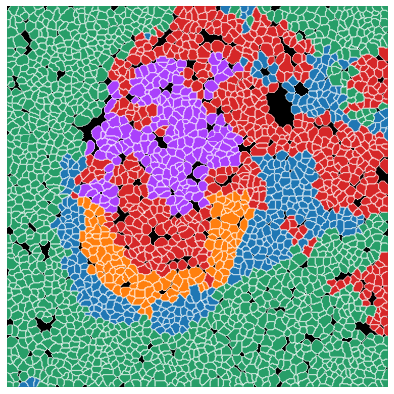

  0%|          | 0/6 [00:00<?, ?it/s]

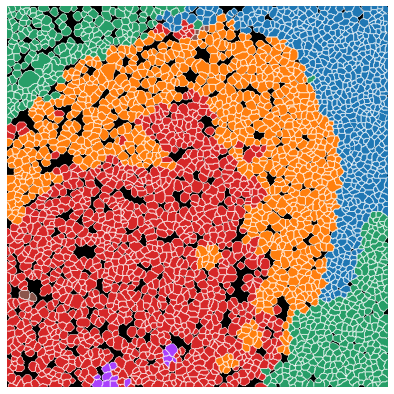

In [249]:
for dataset in adata_CN.obs['Core'].unique():
    adata_fov = adata_CN[adata_CN.obs['Core'] == dataset]
    try:
        mask = masks["_".join([experiment, dataset])]
        contours = get_contour(mask)
    except:
        print(dataset)
        continue
     # Get label2cell dict
    
    label2cell = {}
    for i, l in enumerate(labels):
        cell_id = adata_fov[adata_fov.obs.CN == l].obs.Cell.to_list()
        label2cell[i] = cell_id

    img = create_clustered_cell(mask, label2cell, colors_rgb)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img)
    for j, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="white")
    ax.axis("off")
    plt.show()


# Name zone

In [250]:
type_dict = {0: 'Outside GC',
            1: 'GC Light Zone',
            2: 'Outside GC', 
            3: 'GC Light Zone',
            4: 'GC Dark Zone',
            5: 'GC Light Zone'
            }

In [251]:
adata_CN.obs['Type'] = (
    adata_CN.obs['CN']
    .map(type_dict)
    .astype("category")
)
adata_CN.uns['Type_colors'] = adata_CN.uns['CN_colors'][:len(np.unique(adata_CN.obs['Type']))]

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Type']`


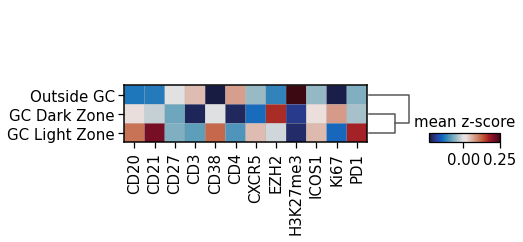

In [252]:
sc.tl.dendrogram(adata_CN, groupby='Type')

sc.pl.matrixplot(
    adata_CN,
    adata_CN.raw.var_names.tolist(),
    "Type",
    dendrogram=True,
    colorbar_title="mean z-score",
    cmap=heatmap_cmp,
    swap_axes=False,
    # vmin=-0.25,
    # vmax=0.5
)

In [253]:
df_test = pd.DataFrame()
df_test["Dataset"] = adata_CN.obs["Core"].tolist()
df_test["Type"] = adata_CN.obs["Type"].tolist()

In [254]:
clusters = df_test["Type"].unique().tolist()

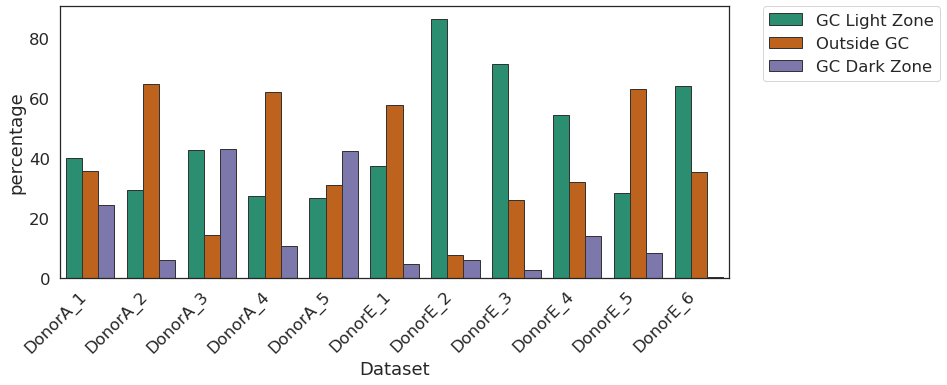

In [255]:
df_test_grouped = (
    df_test.groupby("Dataset")["Type"]
    .value_counts(normalize=True)
    .rename("percentage")
    .mul(100)
    .reset_index()
)

with sns.axes_style("white"):
    sns.barplot(
        data=df_test_grouped,
        x="Dataset",
        y="percentage",
        hue="Type",
        palette="Dark2",
        edgecolor=".2"
    )
    plt.gcf().set_size_inches(12, 5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.xticks(rotation=45, ha='right')


In [256]:
cluster_label_order = adata_CN.uns['dendrogram_Type']['categories_ordered']

In [257]:
import matplotlib 

colors = adata_CN.uns["Type_colors"]
labels = adata_CN.obs.Type.cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

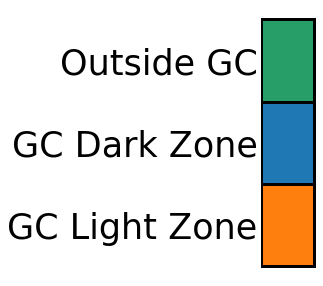

In [258]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,5))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


In [259]:
colors = adata_CN.uns["Type_colors"]
labels = np.unique(adata_CN.obs.Type.tolist())

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

  0%|          | 0/3 [00:00<?, ?it/s]

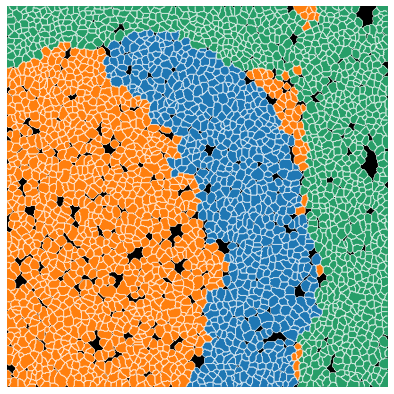

  0%|          | 0/3 [00:00<?, ?it/s]

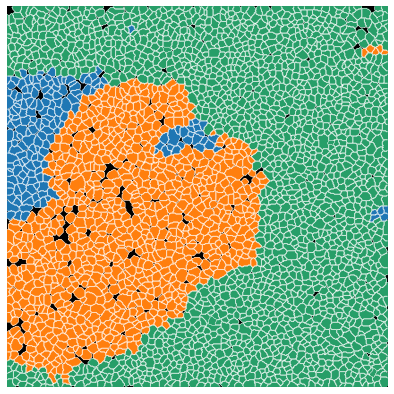

  0%|          | 0/3 [00:00<?, ?it/s]

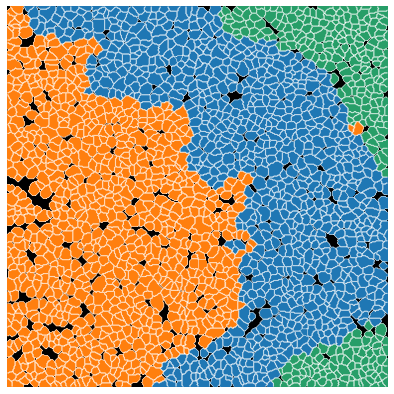

  0%|          | 0/3 [00:00<?, ?it/s]

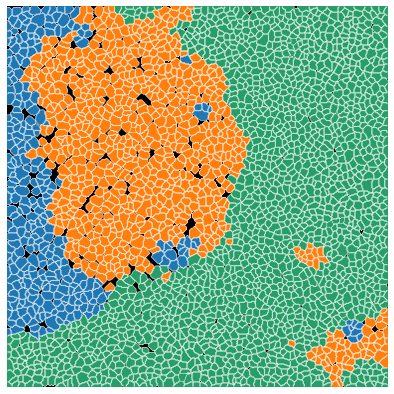

  0%|          | 0/3 [00:00<?, ?it/s]

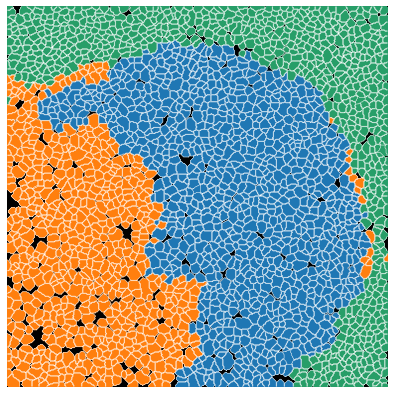

  0%|          | 0/3 [00:00<?, ?it/s]

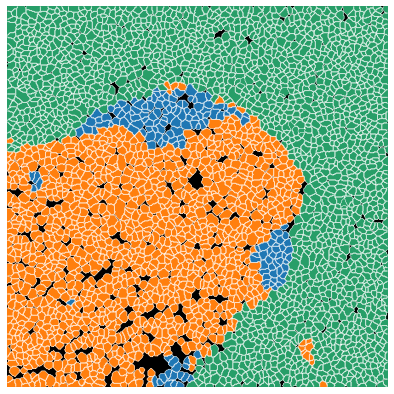

  0%|          | 0/3 [00:00<?, ?it/s]

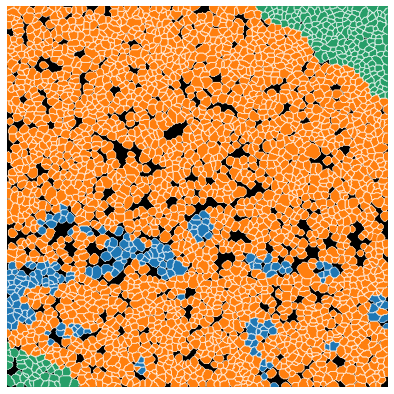

  0%|          | 0/3 [00:00<?, ?it/s]

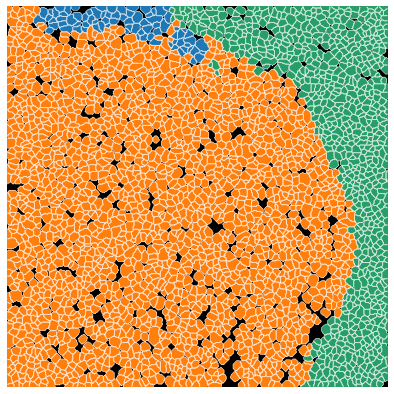

  0%|          | 0/3 [00:00<?, ?it/s]

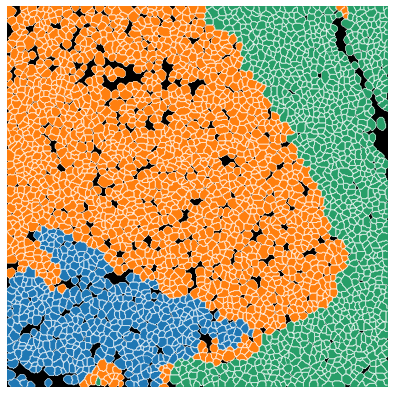

  0%|          | 0/3 [00:00<?, ?it/s]

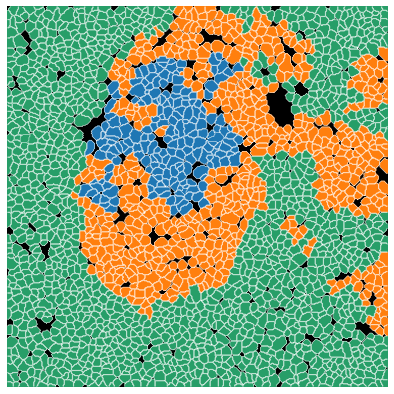

  0%|          | 0/3 [00:00<?, ?it/s]

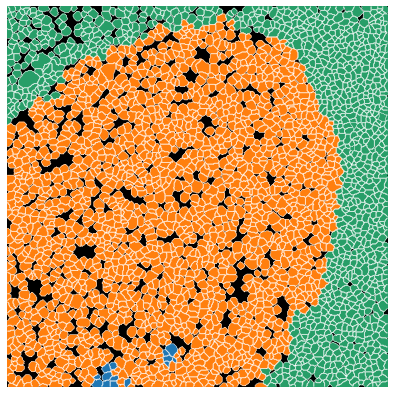

In [260]:
for dataset in adata_CN.obs['Core'].unique():
    adata_fov = adata_CN[adata_CN.obs['Core'] == dataset]
    try:
        mask = masks["_".join([experiment, dataset])]
        contours = get_contour(mask)
    except:
        print(dataset)
        continue
     # Get label2cell dict
    
    label2cell = {}
    for i, l in enumerate(labels):
        cell_id = adata_fov[adata_fov.obs.Type == l].obs.Cell.to_list()
        label2cell[i] = cell_id

    img = create_clustered_cell(mask, label2cell, colors_rgb)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img)
    for j, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="white")
    ax.axis("off")
    plt.show()


# Get SIMS data

In [292]:
# Read litterature lut
file_path = data_dir / "metadata" / 'Putative_annotation_05052022.xlsx'
df = pd.read_excel(file_path)
lum = df['m/z'].to_numpy()
SIMS_masses = np.array(adata.var_names.to_list())

# get matched table by looking at difference with error
error = 0.5
matched_dict = {}
for mz in SIMS_masses.astype(float):
    diff = lum-mz
    matched = df[abs(diff)<error]
    if len(matched) > 0:
        matched_dict[mz] = str(mz) + ' ' + matched['Molecules'].item()
    else:
        matched_dict[mz] = str(mz)


In [293]:
adata = adata[:,mz_qc]

In [294]:
adata.obs["Type"] = adata_CN.obs["Type"]
adata.uns["Type_colors"] = adata_CN.uns["Type_colors"]
adata.obsm["spatial"] = adata_CN.obsm["spatial"]

C:\Users\thu71\AppData\Local\Temp/ipykernel_2160/2958291072.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["Type"] = adata_CN.obs["Type"]
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_Type']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


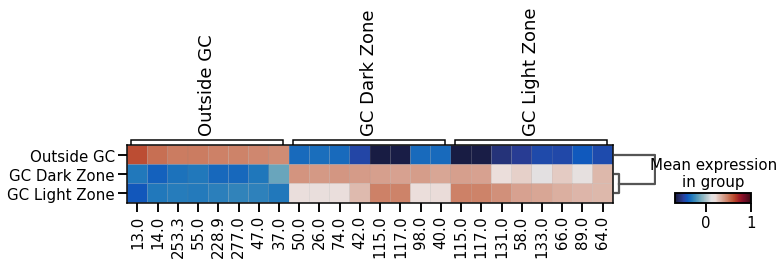

In [295]:
sc.tl.dendrogram(adata, groupby='Type')
sc.tl.rank_genes_groups(adata, groupby='Type', method='t-test_overestim_var')
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=8, use_raw=False, cmap=heatmap_cmp, vmax=1)

In [296]:
# Extract diff expression dataframe
dedf = sc.get.rank_genes_groups_df(adata, group=None)

# Get top diff expression
topk=8
masses_largest = dedf.groupby('group').apply(lambda x: x.nlargest(topk,['scores'])).names.unique()
masses_lowest = dedf.groupby('group').apply(lambda x: x.nsmallest(topk,['scores'])).names.unique()
masses = np.unique(np.concatenate([masses_largest, masses_lowest]))

In [297]:
# Extract dataframe
var = 'Type'

adata_subset = adata[:,masses]
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()

df_SIMS_grouped = df_SIMS.groupby([var]).mean()

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\seaborn\matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


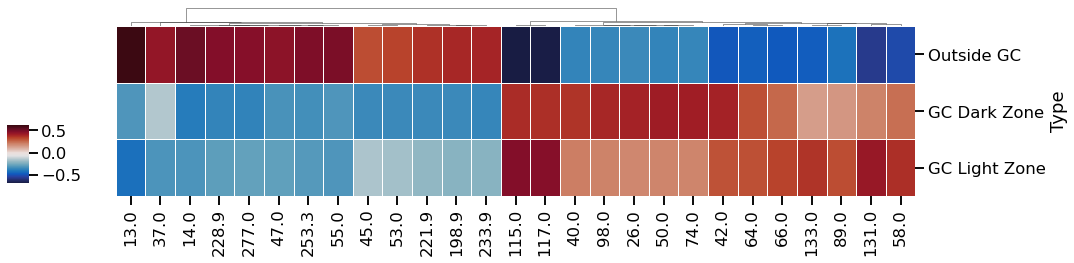

In [298]:
g = sns.clustermap(df_SIMS_grouped,
                   cmap=heatmap_cmp, 
                   row_cluster=True,
                   col_cluster=True,
                   cbar_pos=(.0, .32, .02, .2), 
                   dendrogram_ratio=(.1, .1), 
                   figsize=(15, 4), 
                   yticklabels=True, 
                   xticklabels=True, 
                   linewidths=.75,
                   square=True,
                   # vmax=2.5,
                   # vmin=-2.5
                  )
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center')
g.ax_row_dendrogram.set_visible(False)



In [299]:
# Get subset of masses
adata_subset = adata[:,masses]

# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
# df_SIMS.drop(['1.0'], axis=1, inplace=True)

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))
df = df_SIMS_var[df_SIMS_var[var] == 'GC Dark Zone'].groupby('mz').mean()
df.sort_values('Normalized ion count', inplace=True)
masses_sorted = df.index.tolist()

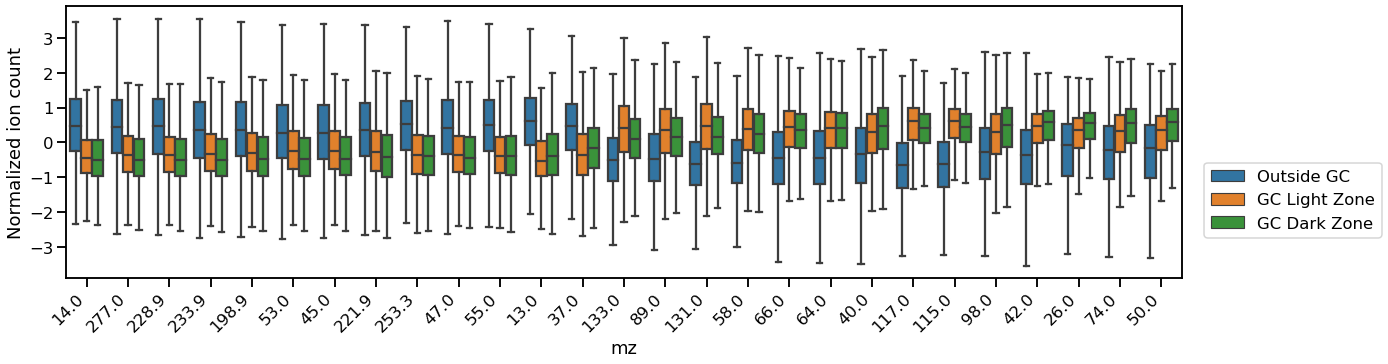

In [300]:
sns.set_context('talk', font_scale=1)

fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(data=df_SIMS_var, 
            hue=var, 
            x='mz', 
            y='Normalized ion count',
            order=masses_sorted,
            # hue_order = ['GC Mantle Zone', 'T cell zone', 'GC TFH cells', 'GC Dark Zone', 'GC Light Zone'],
            ax=ax, 
            palette='tab10', 
            showfliers=False)
plt.xticks(rotation = 45, ha='right')
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='lower left', borderaxespad=0)


### Groupby Type

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_Type']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
categories: GC Dark Zone, GC Light Zone, Outside GC
var_group_labels: GC Dark Zone, GC Light Zone


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


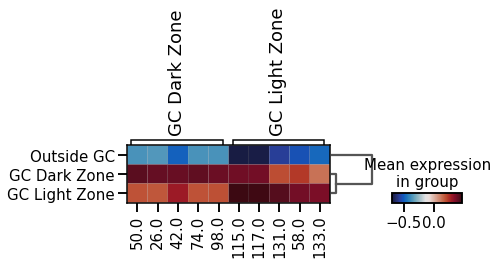

In [302]:
groups = ['GC Dark Zone', 'GC Light Zone']
sc.tl.dendrogram(adata, groupby='Type')
sc.tl.rank_genes_groups(adata, groupby='Type', method='wilcoxon', groups=groups)
sc.pl.rank_genes_groups_matrixplot(adata, groups=groups, n_genes=5, use_raw=False, cmap=heatmap_cmp)

In [283]:
# Extract diff expression dataframe
dedf = sc.get.rank_genes_groups_df(adata, group=None)

# Get top diff expression
topk=5
masses_largest = dedf.groupby('group').apply(lambda x: x.nlargest(topk,['scores'])).names.unique()
masses_lowest = dedf.groupby('group').apply(lambda x: x.nsmallest(topk,['scores'])).names.unique()
masses = np.unique(np.concatenate([masses_largest, masses_lowest]))

In [286]:
# Extract dataframe
var = 'Type'

adata_subset = adata[:,masses]
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
df_SIMS = df_SIMS[df_SIMS[var].isin(groups)]
# df_SIMS.drop(['1.0'], axis=1, inplace=True)

df_SIMS_grouped = df_SIMS.groupby([var]).mean()

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\seaborn\matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


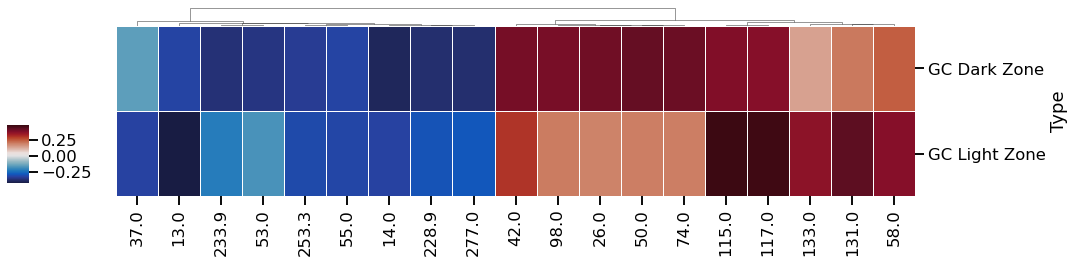

In [287]:
g = sns.clustermap(df_SIMS_grouped,
                   cmap=heatmap_cmp, 
                   row_cluster=True,
                   col_cluster=True,
                   cbar_pos=(.0, .32, .02, .2), 
                   dendrogram_ratio=(.1, .1), 
                   figsize=(15, 4), 
                   yticklabels=True, 
                   xticklabels=True, 
                   linewidths=.75,
                   square=True,
                   # vmax=2.5,
                   # vmin=-2.5
                  )
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center')
g.ax_row_dendrogram.set_visible(False)



In [288]:
# Get subset of masses
adata_subset = adata[:,masses]

# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
df_SIMS = df_SIMS[df_SIMS[var].isin(groups)]
# df_SIMS.drop(['1.0'], axis=1, inplace=True)

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))
df = df_SIMS_var[df_SIMS_var.Type == 'GC Light Zone'].groupby('mz').mean()
df.sort_values('Normalized ion count', inplace=True)
masses_sorted = df.index.tolist()

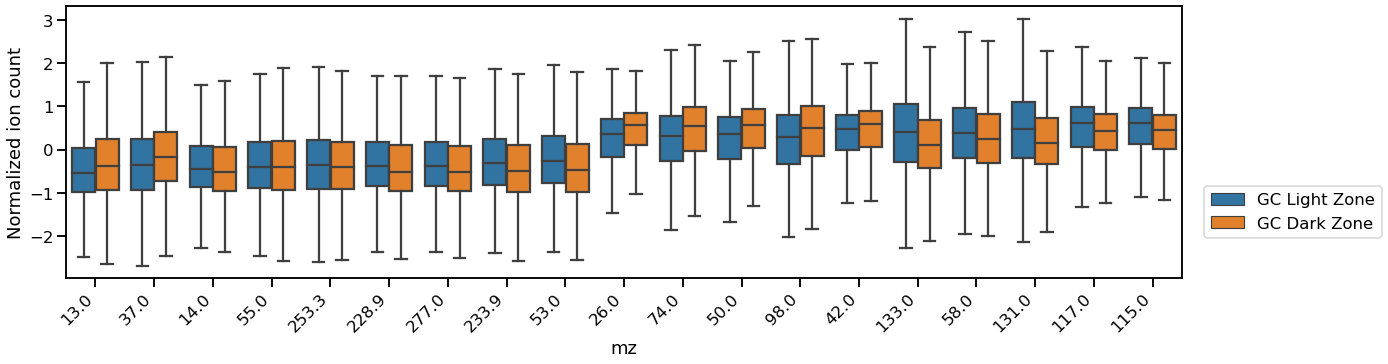

In [289]:
sns.set_context('talk', font_scale=1)

df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))

fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(data=df_SIMS_var, 
            hue=var, 
            x='mz', 
            y='Normalized ion count',
            order=masses_sorted,
            # hue_order = ['Outside Follicle', 'Follicle Zone', 'GC Light Zone', 'GC Dark Zone'],
            ax=ax, 
            palette='tab10', 
            showfliers=False)
plt.xticks(rotation = 45, ha='right')
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='lower left', borderaxespad=0)


### Plot by mz channel

In [ ]:
import palettable
h5_data_dir = p_dir / "data" / "h5"
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap

def get_imgs_sims(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["labels"])
    return imgs[2:], labels[2:]

def IMS(imgs, mz, masses):
    mz_img = imgs[np.equal(masses, mz),...][0]
    # fig, ax = plt.subplots(figsize=(7,7))
    # ax.imshow(mz_img, cmap=heatmap_cmp, interpolation='quadric', vmin=0,vmax=np.percentile(mz_img, 99))  
    # ax.axis('off')
    # plt.title(f'{mz} m/z')
    # plt.show()
    return mz_img 

In [ ]:
# channel = 58.0
# masses = np.array(df_intensity_TS.columns.tolist()).astype(float)

# for dataset in datasets:
#     try:
#         # --- Read tof-sims images
#         imgs, labels = get_imgs_sims(experiment, 'auto_'+dataset)
#         mz_img = IMS(imgs, channel, masses)
        
#         path = p_dir / 'figures' / 'mz' / f'{experiment}_{channel}_{dataset}.tiff'
#         fig, ax = plt.subplots(figsize=(7,7))
#         ax.imshow(mz_img, cmap=heatmap_cmp, interpolation='quadric', vmin=0,vmax=np.percentile(mz_img, 95))  
#         ax.axis('off')
#         fig.savefig(path, bbox_inches='tight', transparent=True, pad_inches=0)
#     except:
#         continue